# Zadanie 1. Celem zadania jest zapoznanie się z metodą analizy głównych składowych (ang. Principal Component Analysis, PCA). Pracować będziemy na zbiorze Plantdoc dataset1. Jest to zbiór zdjęć przedstawiający choroby popularnych roślin uprawnych.

## Preprocesing danych

### 1. Wybierz ze zbioru Plantdoc podzbiór kilkudziesięciu (np. 60) zdjęć przedstawiających trzy choroby roślin jednego gatunku (np. 3 choroby ziemniaków lub 3 choroby pomidorów, po 20 zdjęć dla każdej choroby).

#### Wybrano choroby pomidorów
#### - Tomato Septoria leaf spot
#### - Tomato leaf bacterial spot
#### - Tomato leaf mosaic virus

### zmiana nazw plików zdjęciowych aby ułatwić rozróżnianie chorób

In [1]:
# import os

# # Ścieżka do folderu z plikami
# folder_path = "choroba3"

# # Pobierz listę plików w folderze
# files = os.listdir(folder_path)

# # Zainicjuj zmienną licznikową
# count = 41

# # Iteruj przez każdy plik w folderze
# for filename in files:
#     # Buduj nową nazwę pliku z numerem
#     new_filename = str(count) + ".jpg"  # Zmiana rozszerzenia pliku jeśli potrzebne
    
#     # Buduj pełną ścieżkę do pliku
#     old_filepath = os.path.join(folder_path, filename)
#     new_filepath = os.path.join(folder_path, new_filename)
    
#     # Zmień nazwę pliku
#     os.rename(old_filepath, new_filepath)
    
#     # Zwiększ licznik
#     count += 1


### 2. Wczytaj zdjęcia do pamięci. Po wczytaniu każde zdjęcie będzie trójwymiarowym tensorem. Można wykorzystać funkcję matplotlib.imread albo wykorzystać bibliotkę imageio lub Pillow.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images


### 3. Przeskaluj wszystkie zdjęcia do rozdzielczości 224 × 224, tak aby wszystkie obrazy miały ten sam rozmiar, równy 224 × 224 × 3.

In [4]:
def resize_images(images, target_size=(224, 224)):
    resized_images = []
    for img in images:
        resized_img = img.resize(target_size)
        resized_images.append(resized_img)
    return resized_images


In [5]:
# Wczytanie zdjęć z folderu
folder_path = "choroby_sort"
images = load_images_from_folder(folder_path)

resized_images = resize_images(images)

# Konwersja do tablicy numpy
resized_image_tensors = np.array([np.array(img) for img in resized_images])

# Sprawdzenie nowych wymiarów
print("Shape of resized image tensors:", resized_image_tensors.shape)

Shape of resized image tensors: (60, 224, 224, 3)


### 4.Skonwertuj obrazy do skali szarości, tak aby z trójwymiarowego tensora reprezentującego dane zdjęcie otrzymać tablicę dwuwymiarową

In [6]:
def convert_to_grayscale(images):
    grayscale_images = []
    for img in images:
        grayscale_img = img.convert('L')
        grayscale_images.append(grayscale_img)
    return grayscale_images

# Konwersja obrazów do skali szarości
grayscale_images = convert_to_grayscale(resized_images)

# Konwersja do tablicy numpy
grayscale_image_arrays = np.array([np.array(img) for img in grayscale_images])

# Sprawdzenie nowych wymiarów
print("Shape of grayscale image arrays:", grayscale_image_arrays.shape)

Shape of grayscale image arrays: (60, 224, 224)


### 5. Skonwertuj obrazy, będące teraz tablicami dwuwymiarowymi (macierzami) na wektory. Pomocna będzie jedna z funkcji: np.reshape, np.ravel, np.flatten. Funkcje np.reshape i np.ravel zwracają, gdy tylko jest to możliwe, widok oryginalej tablicy. Funkcja np.flatten zwraca kopię tablicy, co zwykle jest niepożądane. Każdy obraz powinien być teraz reprezentowany przez wektor o rozmiarze 50 176

In [7]:
def convert_to_vectors(images):
    image_vectors = []
    for img in images:
        img_vector = np.reshape(img, -1)
        image_vectors.append(img_vector)
    return image_vectors

# Konwersja obrazów do wektorów
image_vectors = convert_to_vectors(grayscale_image_arrays)

# Sprawdzenie rozmiaru wektorów
print("Size of each image vector:", image_vectors[0].shape)

# Sprawdzenie liczby wektorów
print("Number of image vectors:", len(image_vectors))

Size of each image vector: (50176,)
Number of image vectors: 60


### 6. Przeprowadź centrowanie zbioru, czyli od każdego obrazu odemij średni obraz. W tym momencie wycentrowany zbiór zdjęć możemy reprezentować jako tablicę X o wymiarze 60 × 50176

In [8]:
def center_dataset(image_vectors):
    # Obliczanie średniego obrazu
    m_image = np.mean(image_vectors, axis=0)
    
    # Odjęcie średniego obrazu od każdego wektora obrazu
    centered_images = [img - m_image for img in image_vectors]
    
    return m_image, centered_images

# Centrowanie zbioru i zapisanie średniego obrazu na potem
mean_image, centered_image_vectors = center_dataset(image_vectors)

# Konwersja na tablicę numpy
X = np.array(centered_image_vectors)

# Sprawdzenie wymiarów
print("Shape of centered dataset X:", X.shape)
print(mean_image.shape)

Shape of centered dataset X: (60, 50176)
(50176,)


## Analiza głównych składowych

### 1. Wykonaj transformację PCA. Realizacja możliwa jest na kilka sposobów:
#### --> (a) Poprzez użycie funkcji sklearn.decomposition.PCA. Nie mamy jednak głębszego wglądu w działanie metody.
#### (b) Poprzez rozkład macierzy X według wartości osobliwych, X = U ΣV ^T , a następnie wyliczenie macierzy Z = XV .
#### (c) Poprzez wyliczenie wektorów i wartości własnych macierzy kowarianacji, tj. 1/n X^T X. Wadą tego podejścia może być duże obciążenie pamięciowe, gdyż rozmiar macierzy kowariancji wynosi m × m, gdzie m jest liczbą cech.

In [9]:
from sklearn.decomposition import PCA

# Utworzenie instancji PCA
n_components=10
pca = PCA(n_components)  # Określenie liczby składowych do zachowania

# Dopasowanie PCA do danych i transformacja danych
Z = pca.fit_transform(X)

# Wyświetlenie wyjaśnionej wariancji
print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.26181127 0.06858171 0.0547175  0.04256725 0.03347421 0.03042401
 0.0287035  0.02641707 0.02490861 0.02036193]


### 2. Jak wyglądała dla tego zbioru macierz kowariancji przed transformacją PCA, a jak po jej wykonaniu?

In [10]:
# Obliczenie macierzy kowariancji przed PCA
covariance_matrix_before_pca = np.dot(X.T, X) 

print("Covariance matrix before PCA:\n", covariance_matrix_before_pca)

# Utworzenie instancji PCA
pca = PCA(n_components)

# Dopasowanie PCA do danych i transformacja danych
Z = pca.fit_transform(X)

# Obliczenie macierzy kowariancji po PCA
covariance_matrix_after_pca = np.cov(Z.T)

# Wyświetlenie macierzy kowariancji przed i po PCA
print("\nCovariance matrix after PCA:\n", covariance_matrix_after_pca)

Covariance matrix before PCA:
 [[243782.4        240157.2        236296.2        ...  80044.6
   77162.          84112.8       ]
 [240157.2        250884.18333333 249844.85       ...  78157.55
   78395.25        86625.65      ]
 [236296.2        249844.85       254852.85       ...  78273.55
   79932.25        85564.65      ]
 ...
 [ 80044.6         78157.55        78273.55       ... 245067.65
  235239.75       226283.95      ]
 [ 77162.          78395.25        79932.25       ... 235239.75
  240363.25       226852.25      ]
 [ 84112.8         86625.65        85564.65       ... 226283.95
  226852.25       228600.85      ]]

Covariance matrix after PCA:
 [[ 4.42499949e+07 -1.20091980e-10  1.81441376e-09  4.89999959e-09
  -1.08063715e-09  1.27892630e-09 -1.37731685e-09  2.61486451e-10
   6.60152557e-10 -3.54091688e-10]
 [-1.20091980e-10  1.15913275e+07 -7.94945530e-10  1.33815180e-09
  -1.72042271e-10 -5.77414833e-10  1.08811934e-09  7.76405985e-10
  -8.05526072e-10 -3.29466754e-10]
 [ 1.

### 3. Jak wyglądało średnie zdjęcie, które odjęliśmy od pozostałych, by wycentrować zbiór?

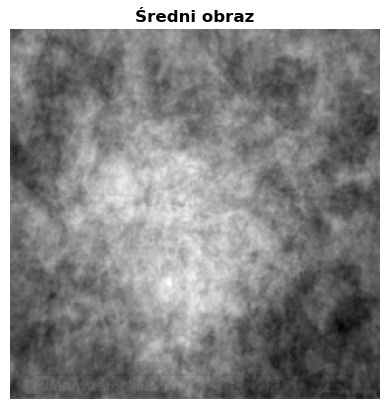

In [11]:
# Średni obraz jest już zapisany
# mean_image 

# Konwersja średniego obrazu z wektora na macierz o wymiarach 224x224
mean_image_matrix = mean_image.reshape(224, 224)

# Wyświetlenie średniego obrazu
plt.imshow(mean_image_matrix, cmap='gray')
plt.axis('off')
plt.title('Średni obraz')
plt.show()

### 4. Jak wyglądają znalezione nowe wektory bazowe (ang. principal axes)? Zaprezentuj je posortowane według powiązanej wariancji. Zauważ, że wektory bazowe też są wektorami z oryginalnej przestrzeni. Ponieważ oryginalna przestrzeń zawierała zdjęcia, to znalezioną nową, lepszą bazę możemy również zwizualizować w postaci obrazów, tak jak średnią fotografię z poprzedniego punktu.

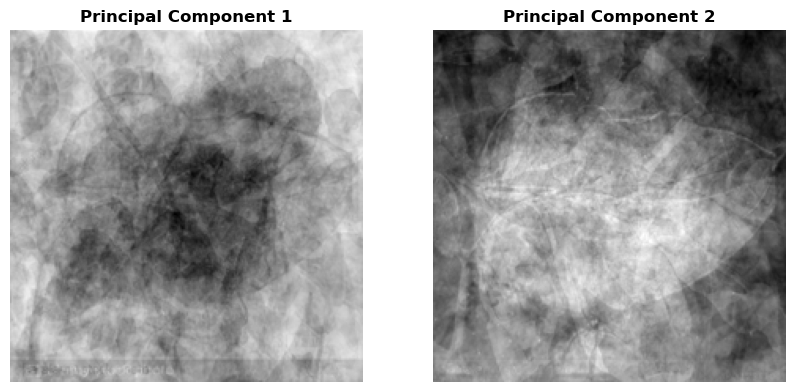

In [12]:
# Pobranie wektorów bazowych (głównych składowych) z modelu PCA
principal_components = pca.components_

# Sortowanie wektorów bazowych według powiązanej wariancji (współczynnika wyjaśnionej wariancji)
sorted_indices = np.argsort(pca.explained_variance_ratio_)[::-1]  # Sortowanie malejąco
sorted_principal_components = principal_components[sorted_indices]

# Wyświetlenie wektorów bazowych jako obrazów
plt.figure(figsize=(10, 5))
for i in range(2):  # Wyświetlenie dwóch głównych składowych
    plt.subplot(1, 2, i + 1)
    pc_matrix = sorted_principal_components[i].reshape(224, 224)  # Przekształcenie wektora bazowego na macierz obrazu
    plt.imshow(pc_matrix, cmap='gray')
    plt.title('Principal Component {}'.format(i + 1))
    plt.axis('off')
plt.show()

### 5. Zredukuj wymiarowość obserwacji do odpowiednio 3, 9 i 27 najważniejszych składowych, czyli cech w nowej bazie (ang. principal components). Jak wyglądają tak ”odchudzone” z wymiarów zdjęcia? Żeby odpowiedzieć na to pytanie wykonaj poniższe kroki.
#### (a) Wyzeruj wszystkie wartości składowych, poza wybranymi najważniejszymi składowymi.

In [13]:
# Wybór liczby najważniejszych składowych
num_components = [3, 9, 27]

# Zerowanie składowych poza najważniejszymi
zeroed_components = []
for num in num_components:
    zeroed_component = np.zeros_like(principal_components)
    zeroed_component[:, :num] = principal_components[:, :num]
    zeroed_components.append(zeroed_component)

#### (b) Przetransformuj tak zmodyfikowane zdjęcia do oryginalnej bazy.

In [14]:
# Przetransformowanie zmodyfikowanych zdjęć do oryginalnej bazy

transformed_images = []
for component in zeroed_components:
    transformed_image = np.dot(Z, component)
    transformed_images.append(transformed_image)

#### (c) Do każdego zdjęcia dodaj średni wektor, odwracając wycentrowanie.

In [15]:
recentered_images = []

for image in transformed_images:
    recentered_image = image[0]
    recentered_image = recentered_image + mean_image
    recentered_images.append(recentered_image)

#### (d) Przekształć wektor do kształtu zdjęcia i wyświetl.

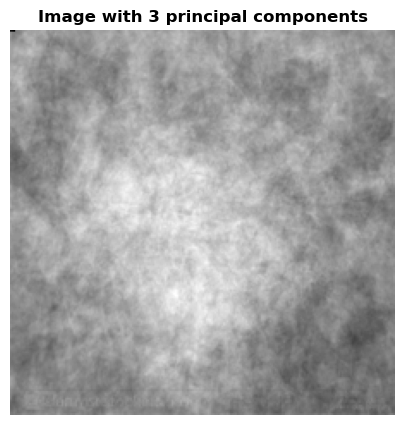

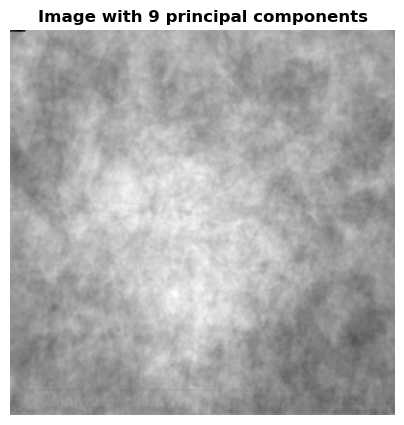

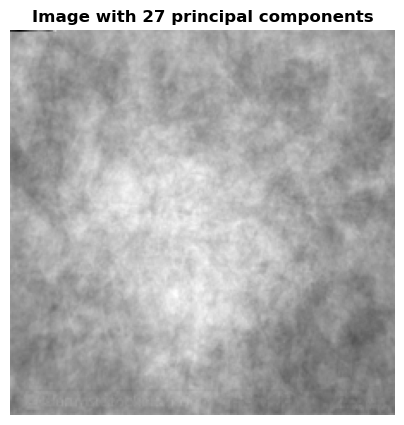

In [16]:
# Przekształcenie wektora do kształtu zdjęcia i wyświetlenie
for i, image in enumerate(recentered_images):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.reshape(224, 224), cmap='gray')
    plt.title('Image with {} principal components'.format(num_components[i]))
    plt.axis('off')
    plt.show()

### 6. Na koniec użyj PCA do zrzutowania zbioru na płaszczyznę.
#### (a) Zredukuj wymiarowość do 2 najważniejszych aspektów danych. Nie zeruj odrzucanych cech, zamiast tego skróć wektory (obserwacje powinny stać się wektorami dwuwymiarowymi).


In [17]:
import matplotlib.pyplot as plt

# Utwórz instancję PCA z dwoma składowymi
pca_2d = PCA(n_components=2)

# Dopasuj PCA do danych i przekształć je do dwóch najważniejszych składowych
Z_2d = pca_2d.fit_transform(X)

#### (b) Użyj tych wektorów 2D jako współrzędnych na płaszczyźnie. Każdą obserwację zaznacz markerem, uzależniając kolor lub kształt markera od rodzaju choroby, którą przedstawiało dane zdjęcie

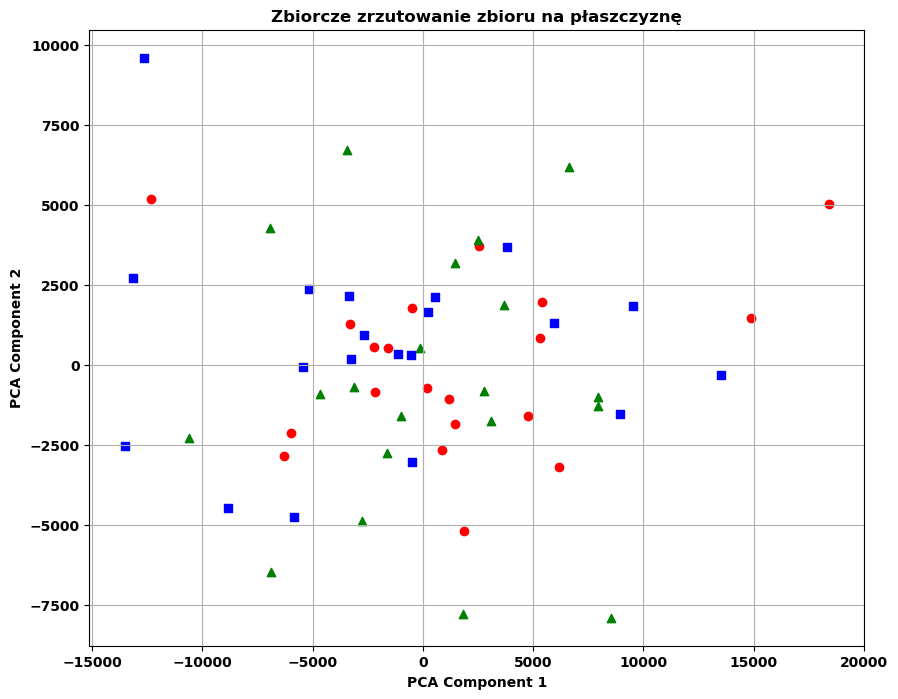

In [18]:
# Utwórz wykres punktowy
plt.figure(figsize=(10, 8))

# Zdefiniuj kolory lub kształty markerów dla różnych chorób
#### - Tomato Septoria leaf spot
#### - Tomato leaf bacterial spot
#### - Tomato leaf mosaic virus
colors = ['r', 'g', 'b']  
markers = ['o', '^', 's']  # Dla każdej choroby inny kształt

# Iteruj po danych i zaznacz je na wykresie
for i in range(len(Z_2d)):
    # Uzyskaj kolor i kształt markera na podstawie rodzaju choroby
    color = colors[i // 20]  # 20 zdjęć dla każdej choroby
    marker = markers[i // 20]
    plt.scatter(Z_2d[i, 0], Z_2d[i, 1], color=color, marker=marker)

plt.title('Zbiorcze zrzutowanie zbioru na płaszczyznę')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

## 7. Przedstaw wykres wariancji wyjaśnionej w zależności od liczby głównych składowych

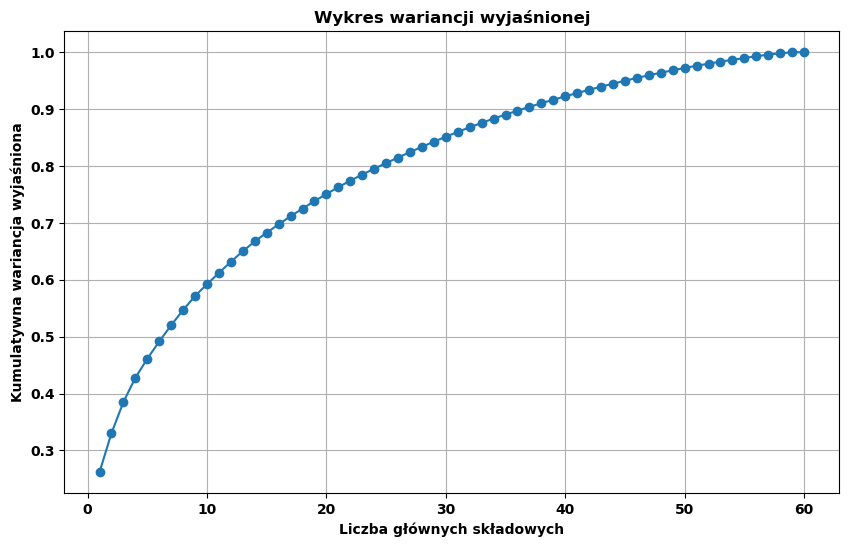

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Utwórz instancję PCA z pełną liczbą składowych
pca_full = PCA()

# Dopasuj PCA do danych
pca_full.fit(X)

# Oblicz procentową wariancję wyjaśnioną dla każdej składowej
explained_variance_ratio = pca_full.explained_variance_ratio_

# Oblicz kumulatywną sumę wariancji wyjaśnionej
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Utwórz wykres
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o', linestyle='-')
plt.title('Wykres wariancji wyjaśnionej')
plt.xlabel('Liczba głównych składowych')
plt.ylabel('Kumulatywna wariancja wyjaśniona')
plt.grid(True)
plt.show()

# Wnioski
## 2. Jak wyglądała dla tego zbioru macierz kowariancji przed transformacją PCA, a jak po jej wykonaniu?
### W macierzy kowariancji przed transformacją PCA widać, że korelacja pomiędzy pikselami jest wysoka co można zauważyć widząc, że wartości na przekątnej oraz poza nią są sobie bardzo bliskie.
### Po wykonaniu PCA wymiary macierzy się zmniejszyły do 10x10 co odpowiada liczbie głównych składowych wybranych do analizy. Bardzo małe wartości poza przekątną (bliskie zeru) wskazują, że główne składowe są ortogonalne (niezależne) od siebie, co jest jednym z głównych celów PCA.

## 4. Jak wyglądają znalezione nowe wektory bazowe
### Patrzać na nowe wektory bazowe można dostrzec zarys stróktury liścia.

## 6. Na koniec użyj PCA do zrzutowania zbioru na płaszczyznę.
### Na wygenerowanym wykresie zauważyliśmy, że dane są rozrzucone w sposób losowy, co nie pozwala na wyciągnięcie jednoznacznych wniosków dotyczących struktury lub wzorców w danych. Przyczyn takiego rozrzutu może być kilka:
#### - Mały Zbiór Danych składający się tylko z 60 zdjęć
#### - Zróżnicowanie obrazów np. różne rozdzielczości, oświetlenie, kąty ujęć